# Using SmartAPI Registry metadata in summaries

## Setup

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## packages to work with objects
import requests
import pandas as pd
from textwrap import wrap  ## for plot labels

## to get around bugs
import nest_asyncio
nest_asyncio.apply()

In [2]:
## setup request
# headers = {"content-type": "application/json"}
registry_url = "https://smart-api.info/api/query/?q=__all__&fields=info,tags,_status&raw=1&size=1000"

## make request: check for success (200)
registry_request = requests.get(registry_url, headers={})
registry_request.status_code

200

In [7]:
## get response
registry = registry_request.json()

## parse response to get the information: uptime status, tags, x-translator, api name
registry_data = []
for ele in registry['hits']['hits']:
    tempDict = {'uptimeStatus': ele['_source']['_status'].get('uptime_status'),
                'refreshStatus': ele['_source']['_status'].get('refresh_status'),
                'name': ele['_source']['info']['title']}
    
    if ele['_source'].get('tags'):
        temp = [i.get('name') for i in ele['_source']['tags']]
        tempDict.update({"tags": temp})
    else:
        tempDict.update({"tags": []})
    
    if ele['_source']['info'].get('x-translator'):
        tempDict.update({            
            'team': ele['_source']['info']['x-translator'].get('team'),
            'component': ele['_source']['info']['x-translator'].get('component')
        })
    else:
        tempDict.update({            
            'team': [],
            'component': None
        })
        
    if ele['_source']['info'].get('x-trapi'):
        tempDict.update({            
            'trapi_version': ele['_source']['info']['x-trapi'].get('version')
        })
    else:
        tempDict.update({            
            'trapi_version': None
        })        
        
    registry_data.append(tempDict)

## creating dataframe for easier exploring / printing
registry_df = pd.DataFrame.from_dict(registry_data)
registry_df = registry_df[['name', 'team', 'component', 'trapi_version', 'uptimeStatus', 'refreshStatus', 'tags']]

## changing the column to strings to make it easier to sort values
registry_df['team'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['team']]
registry_df['tags'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['tags']]

## replacing empty strings with None
registry_df['team'] = [None if not x else x for x in registry_df['team']]
registry_df['tags'] = [None if not x else x for x in registry_df['tags']]

## Registry API-level summary

### Comparing translator tag and x-translator use

In [8]:
## make flags whether api has a translator tag or x-translator field
registry_df['hasTranslatorTag'] =  [False if x is None else x 
                                    for x in registry_df.tags.str.contains('translator')]
registry_df['hasXTranslator'] =  [False if x is None else True for x in registry_df.team]

## print table
registry_df[['hasTranslatorTag', 'hasXTranslator']].value_counts().reset_index(name = "Num of APIs")

,hasTranslatorTag,hasXTranslator,Num of APIs
0,False,False,112
1,True,True,80
2,True,False,8
3,False,True,1


### Comparing trapi tag and x-trapi use

In [10]:
## make flags whether api has a translator tag or x-translator field
registry_df['hasTrapiTag'] =  [False if x is None else x 
                                    for x in registry_df.tags.str.contains('trapi')]
registry_df['hasXTrapi'] =  [False if x is None else True for x in registry_df.trapi_version]

## print table
registry_df[['hasTrapiTag', 'hasXTrapi']].value_counts().reset_index(name = "Num of APIs")

,hasTrapiTag,hasXTrapi,Num of APIs
0,False,False,194
1,True,True,5
2,False,True,2


So there are 5 APIs with the "trapi" tag and x-trapi extension. There are 2 APIs with the x-trapi extension and no "trapi" tag. 

### Translator-tagged / x-translator APIs

In [12]:
## grab only the APIs with the translator tag 
translator_apis = registry_df[(registry_df['hasTranslatorTag']) | 
            (registry_df['hasXTranslator'])].copy()

## sort columns and rows to make format similar to Sarah's table
translator_apis = translator_apis[['team', 'component', 'name', 'trapi_version', 'uptimeStatus', 'refreshStatus', 'tags']]
translator_apis.sort_values(by=['team', 'component', 'name'], 
                            ignore_index = True, na_position = 'last', inplace = True)

Translator-tagged APIs with x-translator information. Another review may need to be done to address duplicate API registrations / different API registrations for BTE. 

In [13]:
summarytable1 = translator_apis[~ translator_apis['team'].isna()].copy()
summarytable1

,team,component,name,trapi_version,uptimeStatus,refreshStatus,tags
0,Clinical Data Provider,KP,Columbia Open Health Data (COHD),1.0.0,good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
1,Clinical Data Provider,KP,Columbia Open Health Data (COHD) for COVID-19 ...,1.0.0,good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
2,Clinical Data Provider,KP,OpenPredict API 🔮🐍,1.0.0,good,200,"translator,trapi"
3,Clinical Data Provider,KP,Translator Knowledge Collaboratory API,1.0.0,good,200,"trapi,translator"
4,Connections Hypothesis Provider,KP,Connections Hypothesis Provider API,None,unknown,200,"bayesian,translator,1.0.0"
...,...,...,...,...,...,...,...
76,Standards Reference Implementation Team,Utility,Name Resolver,None,unknown,200,translator
77,Standards Reference Implementation Team,Utility,Node Normalization,None,good,499,Interfaces
78,"Text Mining Provider,Service Provider",KP,Text Mining CO-OCCURRENCE API,None,good,200,"gene,chemical,association,annotation,query,tra..."
79,"Text Mining Provider,Service Provider",KP,Text Mining Targeted Association API,None,good,200,"gene,chemical,association,annotation,query,tra..."


The APIs WITHOUT x-translator information

In [14]:
## APIs without x-translator information
summarytable2 = translator_apis[translator_apis['team'].isna()].copy()
summarytable2.drop(columns = ['team', 'component'], inplace = True)
summarytable2

,name,trapi_version,uptimeStatus,refreshStatus,tags
81,Broad probabilistic graphical models translator,None,unknown,499,translator
82,ChEMBL API,None,good,499,"publication,translator"
83,NCATS ARA Scaffold,None,unknown,499,translator
84,NCATS KP Scaffold,None,unknown,499,translator
85,OpenAPI for indigo NCATS Biomedical Translator...,None,unknown,499,"query,translator,reasoner"
86,RGD API,None,good,499,"translator,gene"
87,ROBOKOP,None,good,499,"translator,reasoner"
88,ROBOKOP Ranker,None,unknown,499,"0.9.2,translator,reasoner"


#### APIs by team

<AxesSubplot:title={'center':'Num of APIs by team'}>

,name,Num of APIs
0,Ranking Agent,27
1,Service Provider,26
2,Standards Reference Implementation Team,6
3,Exposures Provider,5
4,"Multiomics Provider,Service Provider",4
5,Clinical Data Provider,4
6,Expander Agent,2
7,"Text Mining Provider,Service Provider",2
8,Genetics Provider,1
9,Explanatory Agent,1


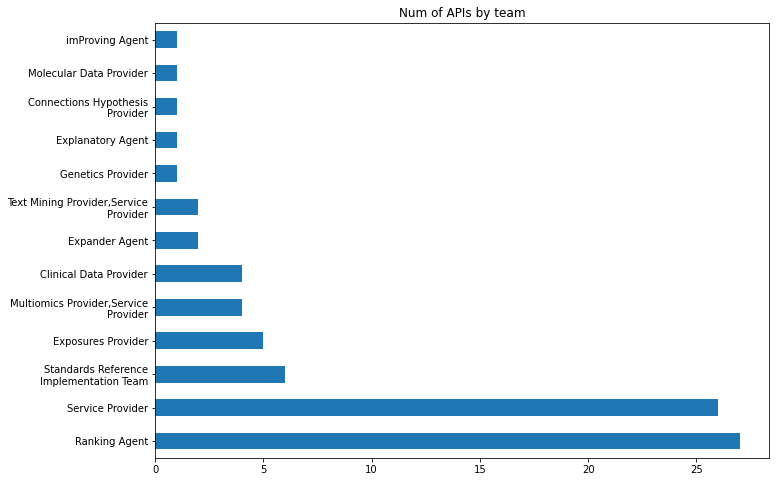

In [15]:
team_summary = translator_apis.team.value_counts().reset_index()
team_summary.columns = ['name', 'Num of APIs']
team_summary['plot_names'] = [ '\n'.join(wrap(i, 30)) for i in team_summary['name']]

team_summary.plot.barh(x='plot_names', y='Num of APIs', fontsize = 10, figsize=(11,8), rot=0, 
                       legend=False, title = "Num of APIs by team", xlabel="")
## table view
team_summary[['name', 'Num of APIs']]

#### APIs by component

,index,component
0,KP,68
1,ARA,8
2,Utility,5


<AxesSubplot:title={'center':'Num of APIs by component type'}>

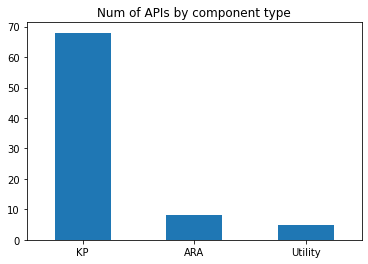

In [16]:
component_summary = translator_apis.component.value_counts().reset_index()
component_summary
component_summary.plot.bar(x='index', y='component', rot=0,
                       legend=False, title = "Num of APIs by component type", xlabel="")

#### APIs by component

,index,component
0,KP,68
1,ARA,8
2,Utility,5


<AxesSubplot:title={'center':'Num of APIs by component type'}>

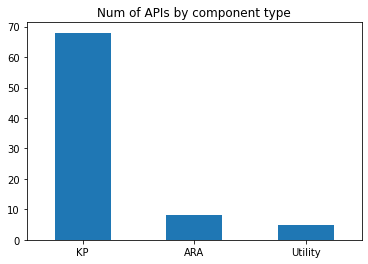

In [16]:
component_summary = translator_apis.component.value_counts().reset_index()
component_summary
component_summary.plot.bar(x='index', y='component', rot=0,
                       legend=False, title = "Num of APIs by component type", xlabel="")

#### APIs by refresh status

,index,refreshStatus
0,200,73
1,499,15
2,299,1


<AxesSubplot:title={'center':'Num of APIs by refresh status'}>

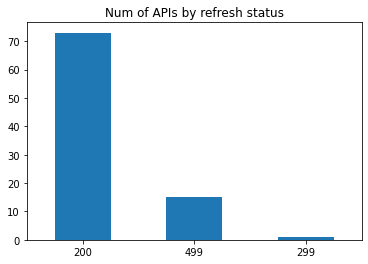

In [18]:
refresh_status_summary = translator_apis.refreshStatus.value_counts().reset_index()
refresh_status_summary
refresh_status_summary.plot.bar(x='index', y='refreshStatus', rot=0,
                       legend=False, title = "Num of APIs by refresh status", xlabel="")

## using x-translator and metaKG together

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

### Setup 

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

In [19]:
headers = {"content-type": "application/json"}

metaKG_url = "https://smart-api.info/api/metakg"

metaKG_request = requests.get(metaKG_url, headers={})
metaKG_request.status_code
## if the output is successful, code 200

200

In [20]:
metaKG = metaKG_request.json()

metaKG_operations = []
for edge in metaKG['associations']:
    tempdict = {
        "subject": edge['subject'],
        "object": edge['object'],
        "predicate": edge['predicate'],
        "provided_by": edge.get('provided_by'),
        "api_name": edge['api']['name']
    }
    if edge['api'].get('x-translator'):
        tempteam = edge['api']['x-translator'].get('team')
        if isinstance(tempteam, list):
            tempteam = ",".join(tempteam)
            if not tempteam:
                tempteam = None  
        tempdict.update({
            "api_team": tempteam,
            "api_component": edge['api']['x-translator'].get('component'),
        })
    else:
        tempdict.update({
            "api_team": None,
            "api_component": None,
        })
    metaKG_operations.append(tempdict)
    
operations_summary = pd.DataFrame.from_dict(metaKG_operations)

### MetaKG stats

MetaKG describes >1000 operations from 33 translator-tagged APIs

In [21]:
operations_summary.shape
operations_summary.api_name.nunique()

(1270, 7)

32

### predicates by team

In [22]:
operations1 = operations_summary[['predicate', 'api_name', 'api_team']].drop_duplicates()
operations1.api_team.value_counts().reset_index(name = 'Num of unique predicates')

,index,Num of unique predicates
0,Service Provider,159
1,"Multiomics Provider,Service Provider",6
2,"Text Mining Provider,Service Provider",5
3,Standards Reference Implementation Team,3
4,Clinical Data Provider,2
